# Sanity check for the choosen reward model

### libs

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datasets import load_dataset
import openai
import pandas as pd
from datasets import load_dataset
import toml
from tqdm import tqdm

/scratch/cluster/piti/miniconda/envs/loading_models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### model & dataset loading

In [2]:
ds = load_dataset("cleanrl/summarize_from_feedback_oai_preprocessing_1704427060", split="validation")
reward_model_id = "cleanrl/EleutherAI_pythia-1b-deduped__reward__tldr"
tokenizer = AutoTokenizer.from_pretrained(reward_model_id)
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id)
reward_model.eval()

GPTNeoXForSequenceClassification(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((2048,

### shh, its a secret

In [3]:
secrets = toml.load("secrets.toml")
client = openai.OpenAI(api_key=secrets["openai"]["api_key"]) 

### helper funcs for getting rewards, variations of winning response

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_model.to(device)

def get_reward_score(query, response):
    input_text = query + " " + response
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = reward_model(**inputs)
        score = outputs.logits.item()

    return score


In [ ]:
def add_reward(example):
    winning_response = example["response0"] if example["choice"] == 0 else example["response1"]
    reward_input = example["query"] + " " + winning_response
    example["reward_input"] = reward_input
    example["reward_score"] = get_reward_score(example["query"], winning_response)
    return example


In [ ]:
def generate_variations(prompt, response, n_variations=3, model="gpt-4o"):
    messages = [
        {
            "role": "system",
            "content": (
                "You are a paraphrasing assistant. Given a response, generate N alternative phrasings "
                "that convey the same meaning. Do not significantly increase the length of the response "
                "(maximum increase: 10%). Return the variations as a numbered list."
            )
        },
            {
                "role": "user",
                "content": (
                f"Original response: {response}\n\n"
                f"Please provide {n_variations} variations."
            )
        }
    ]

    try:
        result = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.9,
            n=1,
        )

        content = result.choices[0].message.content.strip()
        lines = content.split("\n")
        variations = [
            line.split(".", 1)[-1].strip() if line.strip()[0].isdigit() else line.strip("- ").strip()
            for line in lines if line.strip()
        ]

        return variations[:n_variations]

    except Exception as e:
        print(f"OpenAI error: {e}")
        return [""] * n_variations


In [ ]:
# small_dataset = ds.select(range(100))
small_dataset = ds.shuffle(seed=42).select(range(100))

### generation variations

In [47]:
df = pd.DataFrame(columns=["query", "winning_response", "variations"])
csv_path = "variations.csv"


for idx, item in enumerate(small_dataset):
    query = item["query"]
    winning_response = item["response0"] if item["choice"] == 0 else item["response1"]

    # Generate N variations
    variations = generate_variations(query, winning_response, n_variations=5)

    # Print to console
    print(f"\n[{idx+1}] Winning Response:\n{winning_response}\nVariations:")
    for i, variation in enumerate(variations, 1):
        print(f"{i}. {variation}")

    # Append to DataFrame
    new_row = {
        "query": query,
        "winning_response": winning_response,
        "variations": variations
    }
    df.loc[len(df)] = new_row

    # Save after each row
    df.to_csv(csv_path, index=False)


[1] Winning Response:
 My girlfriend went behind my back to try and control who I'm friends with. Should I break it off or give her another chance?<|endoftext|>
Variations:
1. My girlfriend acted secretly to dictate my friendships. Should I end things or give her another chance?
2. My girlfriend tried to control my friendships without telling me. Should I break up with her or try again?
3. My girlfriend went behind my back to manage who I associate with. Is it time to call it quits or give her a second chance?
4. My girlfriend covertly attempted to influence my choice of friends. Should I consider breaking up or allow her another opportunity?
5. My girlfriend secretly attempted to dictate my friendships. Should I end the relationship or offer her another chance?

[2] Winning Response:
 BF of 3 yrs says he would be okay with me having sex with a male friend of mine, and that he would want a video of that. Not sure what to do or think about this.<|endoftext|>
Variations:
1. My boyfriend

In [7]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

if reward_model.config.pad_token_id is None:
    reward_model.config.pad_token_id = tokenizer.pad_token_id

print("pad_token:", tokenizer.pad_token)
print("pad_token_id (tokenizer):", tokenizer.pad_token_id)
print("pad_token_id (model):", reward_model.config.pad_token_id)


pad_token: <|endoftext|>
pad_token_id (tokenizer): 0
pad_token_id (model): 0


### scoring the winning response and variations

In [ ]:
import ast
df["variations"] = df["variations"].apply(ast.literal_eval) # need to format from "["variation1", "variation2"]" to ["variation1", "variation2"]

In [8]:
main_queries = []
main_responses = []
variation_queries = []
variation_responses = []

# Collect all inputs first
for _, row in tqdm(df.iterrows(), total=len(df), desc="Collecting inputs"):
    query = row["query"]
    winning_response = row["winning_response"]
    variations = row["variations"]

    main_queries.append(query)
    main_responses.append(winning_response)

    variation_queries.extend([query] * len(variations))
    variation_responses.extend(variations)

# Compute scores in batches
main_scores = get_reward_scores(main_queries, main_responses)
variation_scores_flat = get_reward_scores(variation_queries, variation_responses)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [35]:
from tqdm import tqdm

main_scores = []
variation_scores_flat = []

# Loop over rows with tqdm progress bar
for _, row in tqdm(df.iterrows(), total=len(df), desc="Scoring with get_reward_score"):
    query = row["query"]
    winning_response = row["winning_response"]
    variations = row["variations"]

    # Score main response
    main_score = get_reward_score(query, winning_response)
    main_scores.append(main_score)

    # Score each variation
    for variation in variations:
        variation_score = get_reward_score(query, variation)
        variation_scores_flat.append(variation_score)


Scoring with get_reward_score: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


In [37]:
len(variation_scores_flat)

500

In [38]:
variation_rewards = []
i = 0

for row_variations in df["variations"]:
    n = len(row_variations)  # how many variations in this row
    group = variation_scores_flat[i:i + n]

    if len(group) != n:
        raise ValueError(f"Mismatch: expected {n}, got {len(group)} at row {len(variation_rewards)}")

    variation_rewards.append(group)
    i += n


In [39]:
df["variation_rewards"] = variation_rewards
df["variation_reward_mean"] = [sum(v)/len(v) if v else 0.0 for v in variation_rewards]

In [43]:
df["main_reward"] = main_scores

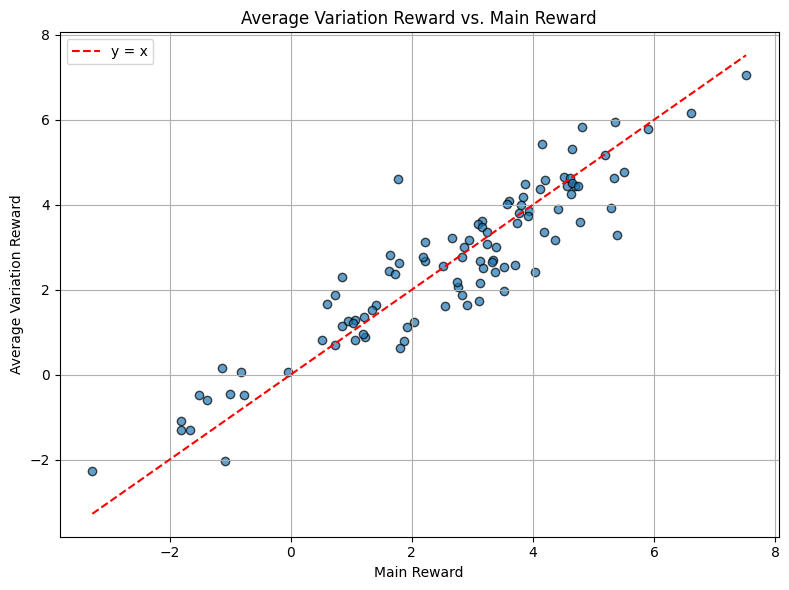

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df["main_reward"], df["variation_reward_mean"], alpha=0.7, edgecolors="k")

# Plot diagonal reference line (y = x)
min_val = min(df["main_reward"].min(), df["variation_reward_mean"].min())
max_val = max(df["main_reward"].max(), df["variation_reward_mean"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")

plt.title("Average Variation Reward vs. Main Reward")
plt.xlabel("Main Reward")
plt.ylabel("Average Variation Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


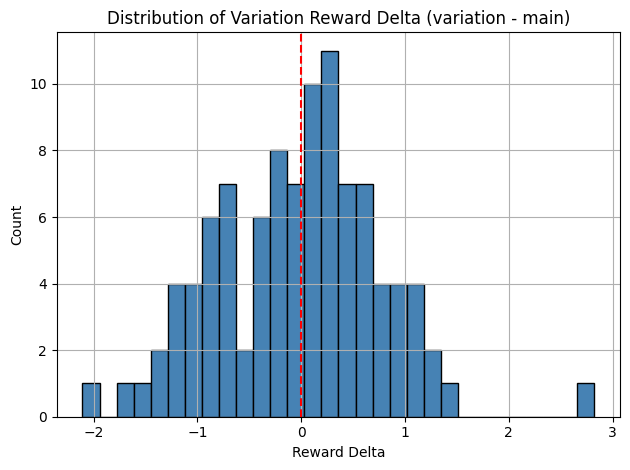

In [48]:
plt.hist(df["delta"], bins=30, color="steelblue", edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of Variation Reward Delta (variation - main)")
plt.xlabel("Reward Delta")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
print("Mean reward delta:", df["delta"].mean())
print("Number of cases where variations > main:", (df["delta"] > 0).sum())
print("Number of cases where variations < main:", (df["delta"] < 0).sum())


Mean reward delta: -0.02772225618362426
Number of cases where variations > main: 52
Number of cases where variations < main: 48
